In [1]:
# PARTE 01
#Questões de negócio 
#1 - Quais são os imóveis que a House Rocket deveria comprar e por qual preço? 
#2 - Uma vez o imóvel comprado, qual o melhor momento para vende-lo e por qual preço?

In [3]:
import pandas as pd

In [6]:
import numpy  as np
import pandas as pd
import seaborn as sns


from matplotlib import gridspec
from matplotlib import pyplot     as plt
import ipywidgets     as widgets
import plotly.express as px
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.core.display import HTML

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12,6]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 25
    pd.set_option ('display.expand_frame_repr', False)
    sns.set()
jupyter_settings()
 
def get_data(path):
    
    data = pd.read_csv(path)
    
    return data

def analysis_data (data):
    
    data_types = data.dtypes 
    data_na = data.isna().sum()
    data_describe = data.describe().T
    data_duplicates = len(data) - data["id"].nunique()
    
    return data_types, data_na, data_describe, data_duplicates

def clear_data (data):
    
    data = data.drop_duplicates(subset='id', keep ='last')
    data_drop = data.drop(15870)
    data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
    
    return data

def transform_data (data):

    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    
    data['season'] = data['month'].apply(lambda x: 'spring' if (x >=3) & (x<=5) else 
                                               'summer' if (x >=  6) & (x <= 8) else
                                               'fall' if (x >= 9 ) & (x <= 11) else
                                               'winter')
    data['yr_old'] = data['yr_built'].apply (lambda x: 'old' if (x <= 1955) else 'new')
    data['basement'] = data['sqft_basement'].apply(lambda x: 'yes' if (x != 0) else 'no')
    data['state'] = data['condition'].apply(lambda x: 'good' if (x>=3) else 'bad')
    data['remodeling'] = data['yr_renovated'].apply(lambda x: 'yes' if (x!=0) else 'no')
    data['view_condition'] = data['view'].apply(lambda x: 'good'if (x>=2) else 'bad')
    data['amount_bedrooms'] = data['bedrooms'].apply(lambda x: 'many' if (x>=3) else 'little')
    
    return data
    
def buy_data (data):
    
    price_median = data[['zipcode','price']].groupby('zipcode').median().reset_index()
    
    df = pd.merge(data, price_median, on='zipcode', how='inner')

    df.rename(columns={'price_x': 'price'}, inplace = True)
    df.rename(columns={'price_y': 'price_mediana'}, inplace = True)
    
    for i in range (len(df)):
        if ((data.loc[i, 'price'] < data.loc[i,'price_mediana']) & (data.loc[i,'condition'] > 2)):
            data.loc[i,'status'] = 'compra'
        else:
            data.loc[i,'status'] = 'nao_compra'
    
    resp1 = df[['id','zipcode', 'price','price_mediana','condition','status']].copy()
    
    return resp1

def sale_data(data):
    
    df2 = data[data['status']== 'compra']
    
    price_median2 = df2[['price','zipcode','season']].groupby(['zipcode', 'season']).median('price').reset_index()

    df3 = pd.merge(df2, price_median2, on=['zipcode','season'], how='inner')
    
    df3.rename(columns={'price_x': 'price'}, inplace = True)
    df3.rename(columns={'price_y': 'price_median_season'}, inplace = True)
    
    for i in range(len(df3)):
        data.loc[i, 'seasonality'] = 1.3 if (data.loc[i, 'price'] < data.loc[i, 'price_median_season']) else 1.1
    
    for i in range(len(df3)):
        df3.loc[i,'price_sell'] = df3.loc[i,'price']*df3.loc[i,'seasonality']
        df3.loc[i,'profit'] = df3.loc[i,'price_sell'] - df3.loc[i,'price']
    
    resp2 = df3[['id','zipcode','season','price_median_season','price','price_sell','profit']].copy()
    
    return resp2

#PARTE 02 

#Insights deenvolvidos para estimular novos investimentos

# Hipotese 1 - Imóveis que possuem vista para água, são 30% mais caros na media.

#house_waterfront = data[['price','waterfront']].groupby('waterfront').mean().reset_index()
#sns.barplot(y = house_waterfront['price'], x = house_waterfront['waterfront'])
#house_waterfront 
#1661876.02/533061.43 # False. Pois os imóveis com vista para água são 3x mais valorizados que os imóveis sem vista para água. Evidenciando, que a compra de imóveis 

# Hipotese 2 - Imóveis com data de construção menor que 1955, são 50% mais baratas, na média.

#yr_old = data[['price','yr_old']].groupby('yr_old').mean().reset_index()
#sns.barplot(y = yr_old['price'], x = yr_old['yr_old']) #false
#yr_old
#543873.83/536359.76

# Hipotese 3 - Imóveis sem porão possuem área total 40% maiores do que os imóveis com porão 
#basement_area = data[['sqft_lot','basement']].groupby('basement').mean().reset_index()
#sns.barplot(y = basement_area['sqft_lot'], x = basement_area['basement']);
#basement
#16325.95/13296.86 #False 

# Hipotese 4 - O crescimento do preço dos imóveis YoY é de 10%

#yoy = data[['price','year']].groupby('year').sum().reset_index()
#sns.barplot(y=yoy['price'],x=yoy['year']); #False, de 2014 para 2015, houve uma queda nos preços dos imóveis.
#yoy

# Hipotese 5 - Imóveis com 3 banheiros tem um crescimento de preço MoM de 15%

#bathrooms_price = data[['month','price','bathrooms']].groupby(['month', 'bathrooms']).sum().reset_index()
#bathrooms_price2 = bathrooms_price[bathrooms_price.bathrooms ==3]
#sns.lineplot(y=bathrooms_price2.price, x= bathrooms_price2.month, color = 'black', markers = True, style = (1), legend = False);
#False, o gráfico varia com crescimentos e decaimentos. Os meses de janeiro, fevereiro, e novembro, são bons meses para compra de imóveis com 3 banheiro e os meses abril, maio e junho, são os melhores para venda.

#Hipoteses 6 - Imóveis com condições boas (3 ou mais), são 30% mais caros, na média
#state_houses = data[['price','state']].groupby('state').mean().reset_index()
#sns.barplot(y=state_houses['price'],x=state_houses['state']);
#state_houses
#543528.35/334400.72 # False, casas em bom estado são 62% mais caras. É lucrativo, comprar casas em condições ruins e vender em boas condições. 

#Hipotese 7 - Imóveis que já tiveram pelo menos uma reforma, são 40% mais caros, na média.
#remodeling_houses = data[['price', 'remodeling']].groupby('remodeling').mean().reset_index()
#sns.barplot(y=remodeling_houses['price'], x=remodeling_houses['remodeling']);
#remodeling_houses 
#762118.06/531870.46 #True, as casas que ja foram reformadas pelo menos uma vez, tem um aumento de 40% preço, reafirmando que o negócio de compra/reformar/venda é lucrativo. 

#Hipotese 8 - Casas com porão, são 30% mais caras que as casam sem porão, em média.
#basement_price = data[['price', 'basement']].groupby('basement').mean().reset_index()
#sns.barplot(y=basement_price['price'], x=basement_price['basement']);
#basement_price
#623965.42/488388.76 #True, as casas que possuem porão são 30% mais caras, invista em casa com porão abaixo da média de preços. 

#Hipotese 9 - Casa com boa vista, são 30% mais caras que as casam que não possuem, em média.
#view_good = data[['price','view_condition']].groupby('view_condition').mean().reset_index() 
#sns.barplot(y=view_good['price'], x=view_good['view_condition']);
#view_good
#962781.59/503389.49 #False, casa com boa vista são quase o dobro (91%) do preço das casas com vista ruim, investir em casas com boa vista, abaixo da média, sao lucrativas

#Hipotese 10  - Imóveis com 3 quartos ou mais, são 40% mais caros que os imóveis com menos, em média. 
#bedrooms_houses = data[['price','amount_bedrooms']].groupby('amount_bedrooms').mean().reset_index()
#sns.barplot(y=bedrooms_houses['price'], x=bedrooms_houses['amount_bedrooms']);
#bedrooms_houses
#564678.45/396919.74 #True, investir em casas com mais quartos e que estão abaixo da média, é lucrativo 

if __name__ == "__main__":
    # ETL
    path = r'C:\Users\diego\OneDrive\Área de Trabalho\Comunidade DS\repos\Python do zero ao ds\kc_house_data.csv\kc_house_data.csv'

    # load data
    data = get_data(path)
    analysis_data(data)

    # transform data
    data = clear_data(data) 
    transform_data (data)

    #carge data
    buy_data (data)
    sale_data (data)

Populating the interactive namespace from numpy and matplotlib


C:\Users\diego\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


C:\Users\diego\AppData\Local\Temp/ipykernel_14472/343739034.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')


KeyError: 'price_mediana'

In [4]:
path = r'C:\Users\diego\OneDrive\Área de Trabalho\Comunidade DS\repos\Python do zero ao ds\kc_house_data.csv\kc_house_data.csv'

In [5]:
data = pd.read_csv(path)

In [6]:
# conferindo pelo id se temos dados duplicados

print(f' Existem {len(data) - data["id"].nunique()} dados duplicados no dataset')

 Existem 177 dados duplicados no dataset


In [7]:
#conferindo os tipos das váriaveis
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
#conferindo se tem algum dado faltante 
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,21613.0,4.580302e+09,2.876566e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21613.0,5.400881e+05,3.671272e+05,7.500000e+04,3.219500e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21613.0,3.370842e+00,9.300618e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21613.0,2.114757e+00,7.701632e-01,0.000000e+00,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21613.0,2.079900e+03,9.184409e+02,2.900000e+02,1.427000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21613.0,1.510697e+04,4.142051e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068800e+04,1.651359e+06
floors,21613.0,1.494309e+00,5.399889e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,21613.0,7.541757e-03,8.651720e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21613.0,2.343034e-01,7.663176e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21613.0,3.409430e+00,6.507430e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [10]:
x = data[data['bedrooms'] == 33]
x

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [11]:
#Observamos que temos id duplicados e a data está como um tipo objeto, realizaremos as mudanças necessarias

#excluindo os ids duplicados 
data = data.drop_duplicates(subset='id', keep ='last')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [12]:
#transformando a coluna date, no tipo data
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [13]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,0,2009,0,98103,47.6993,-122.346,1530,1509,5,2014
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,0,2014,0,98146,47.5107,-122.362,1830,7200,2,2015
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,0,2009,0,98144,47.5944,-122.299,1020,2007,6,2014
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,0,2004,0,98027,47.5345,-122.069,1410,1287,1,2015


In [14]:
#deletando linha c 33 banheiros, pois trata-se de um erro de digitação 
data = data.drop(15870)

In [15]:
# Season information

#     Spring: March 20, at 5:37 A.M.
#     Summer: June 20, at 11:32 P.M.
#     Fall: September 22, at 3:21 P.M.
#     Winter: December 21, at 10:59 A.M.
# https://www.calendarr.com/united-states/seasons-of-the-year-in-the-united-states/


data['season'] = data['month'].apply(lambda x: 'spring' if (x >=3) & (x<=5) else 
                                               'summer' if (x >=  6) & (x <= 8) else
                                               'fall' if (x >= 9 ) & (x <= 11) else
                                               'winter')

In [16]:
#Após realizar a coleta e limpeza de dados, vamos começar as análises para responder as questões 
# 1- 

price_median = data[['zipcode','price']].groupby('zipcode').median().reset_index()
price_median

,zipcode,price
0,98001,260000.0
1,98002,235000.0
2,98003,269500.0
3,98004,1150000.0
4,98005,765475.0
...,...,...
65,98177,557000.0
66,98178,279500.0
67,98188,265000.0
68,98198,266750.0


In [17]:
df = pd.merge(data, price_median, on='zipcode', how='inner')

df.rename(columns={'price_x': 'price'}, inplace = True)
df.rename(columns={'price_y': 'price_median'}, inplace = True)

In [18]:
for i in range (len(df)):
    if ((df.loc[i, 'price'] < df.loc[i,'price_median']) & (df.loc[i,'condition'] > 2)):
        df.loc[i,'status'] = 'compra'
    else:
        df.loc[i,'status'] = 'nao_compra'

In [19]:
#Resultado da questão com imóveis classificados em condições de compra

resp1 = df[['id','zipcode', 'price','price_median','condition','status']].copy()
resp1

,id,zipcode,price,price_median,condition,status
0,7129300520,98178,221900.0,279500.0,3,compra
1,4060000240,98178,205425.0,279500.0,4,compra
2,4058801670,98178,445000.0,279500.0,3,nao_compra
3,2976800796,98178,236000.0,279500.0,3,compra
4,6874200960,98178,170000.0,279500.0,3,compra
...,...,...,...,...,...,...
21430,2525049086,98039,2720000.0,1905000.0,4,nao_compra
21431,2525049113,98039,1950000.0,1905000.0,4,nao_compra
21432,3262300485,98039,2250000.0,1905000.0,3,nao_compra
21433,6447300365,98039,2900000.0,1905000.0,3,nao_compra


In [18]:
#data set com Casas que possuem o preço menor que a mediana
df2 = df[df['status']== 'compra']
df2

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,season,price_median,status
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,10,2014,fall,279500.00,compra
1,4060000240,2014-06-23,205425.00,2,1.00,880,6780,1.00,0,0,4,6,880,0,1945,0,98178,47.50,-122.25,1190,6780,6,2014,summer,279500.00,compra
3,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,9,2014,fall,279500.00,compra
4,6874200960,2015-02-27,170000.00,2,1.00,860,5265,1.00,0,0,3,6,860,0,1931,0,98178,47.50,-122.27,1650,8775,2,2015,winter,279500.00,compra
5,4268200055,2015-05-01,245000.00,3,1.75,1740,11547,1.00,0,0,3,7,1740,0,1954,0,98178,47.49,-122.22,880,78408,5,2015,spring,279500.00,compra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21422,3025300225,2014-10-31,1450000.00,5,2.75,3090,19865,1.00,0,0,4,9,3090,0,1953,0,98039,47.62,-122.23,2970,19862,10,2014,fall,1905000.00,compra
21423,2470200020,2014-05-14,1880000.00,4,2.75,3260,19542,1.00,0,0,4,10,2170,1090,1968,0,98039,47.62,-122.24,3480,19863,5,2014,spring,1905000.00,compra
21425,3625049079,2014-08-01,1350000.00,3,2.00,2070,9600,1.00,0,1,3,7,1590,480,1946,0,98039,47.62,-122.24,3000,16215,8,2014,summer,1905000.00,compra
21427,5427100150,2014-06-26,1410000.00,4,2.25,3250,16684,2.00,0,0,3,9,3250,0,1979,0,98039,47.63,-122.23,2890,16927,6,2014,summer,1905000.00,compra


In [19]:
price_median2 = df2[['price','zipcode','season']].groupby(['zipcode', 'season']).median('price').reset_index()

In [20]:
df3 = pd.merge(df2, price_median2, on=['zipcode','season'], how='inner')

df3.rename(columns={'price_x': 'price'}, inplace = True)
df3.rename(columns={'price_y': 'price_median_season'}, inplace = True)

In [21]:
df3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,season,price_median,status,price_median_season
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,10,2014,fall,279500.00,compra,216500.00
1,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,9,2014,fall,279500.00,compra,216500.00
2,1180003090,2014-09-06,190000.00,2,1.00,630,6000,1.00,0,0,3,6,630,0,1943,2005,98178,47.50,-122.22,1470,6840,9,2014,fall,279500.00,compra,216500.00
3,179000350,2014-11-05,194000.00,3,1.50,1010,5000,1.00,0,0,3,6,1010,0,1943,0,98178,47.49,-122.28,980,5000,11,2014,fall,279500.00,compra,216500.00
4,3810000202,2014-09-05,251700.00,3,2.25,1810,11800,1.00,0,0,3,7,1240,570,1977,0,98178,47.50,-122.23,1810,5641,9,2014,fall,279500.00,compra,216500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,5425700150,2014-08-04,787500.00,4,1.75,1580,9382,1.00,0,0,3,7,1080,500,1963,0,98039,47.64,-122.23,2010,9382,8,2014,summer,1905000.00,compra,1335000.00
10501,2525049266,2014-08-21,1762000.00,3,2.25,3060,16000,2.00,0,0,3,10,3060,0,1988,0,98039,47.62,-122.23,3510,13162,8,2014,summer,1905000.00,compra,1335000.00
10502,5427110040,2014-06-09,1225000.00,4,2.50,2740,16007,2.00,0,0,3,9,2740,0,1984,0,98039,47.64,-122.23,2760,16008,6,2014,summer,1905000.00,compra,1335000.00
10503,3625049079,2014-08-01,1350000.00,3,2.00,2070,9600,1.00,0,1,3,7,1590,480,1946,0,98039,47.62,-122.24,3000,16215,8,2014,summer,1905000.00,compra,1335000.00


In [22]:
for i in range(len(df3)):
    df3.loc[i, 'seasonality'] = 1.3 if (df3.loc[i, 'price'] < df3.loc[i, 'price_median_season']) else 1.1

In [23]:
df3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,season,price_median,status,price_median_season,seasonality
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,10,2014,fall,279500.00,compra,216500.00,1.10
1,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,9,2014,fall,279500.00,compra,216500.00,1.10
2,1180003090,2014-09-06,190000.00,2,1.00,630,6000,1.00,0,0,3,6,630,0,1943,2005,98178,47.50,-122.22,1470,6840,9,2014,fall,279500.00,compra,216500.00,1.30
3,179000350,2014-11-05,194000.00,3,1.50,1010,5000,1.00,0,0,3,6,1010,0,1943,0,98178,47.49,-122.28,980,5000,11,2014,fall,279500.00,compra,216500.00,1.30
4,3810000202,2014-09-05,251700.00,3,2.25,1810,11800,1.00,0,0,3,7,1240,570,1977,0,98178,47.50,-122.23,1810,5641,9,2014,fall,279500.00,compra,216500.00,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10500,5425700150,2014-08-04,787500.00,4,1.75,1580,9382,1.00,0,0,3,7,1080,500,1963,0,98039,47.64,-122.23,2010,9382,8,2014,summer,1905000.00,compra,1335000.00,1.30
10501,2525049266,2014-08-21,1762000.00,3,2.25,3060,16000,2.00,0,0,3,10,3060,0,1988,0,98039,47.62,-122.23,3510,13162,8,2014,summer,1905000.00,compra,1335000.00,1.10
10502,5427110040,2014-06-09,1225000.00,4,2.50,2740,16007,2.00,0,0,3,9,2740,0,1984,0,98039,47.64,-122.23,2760,16008,6,2014,summer,1905000.00,compra,1335000.00,1.30
10503,3625049079,2014-08-01,1350000.00,3,2.00,2070,9600,1.00,0,1,3,7,1590,480,1946,0,98039,47.62,-122.24,3000,16215,8,2014,summer,1905000.00,compra,1335000.00,1.10


In [26]:
for i in range(len(df3)):
    df3.loc[i,'price_sell'] = df3.loc[i,'price']*df3.loc[i,'seasonality']
    df3.loc[i,'profit'] = df3.loc[i,'price_sell'] - df3.loc[i,'price']

In [27]:
#Resposta da questão 2, com os preços de venda dos imóveis com condições de venda.

resp2 = df3[['id','zipcode','season','price_median_season','price','price_sell','profit']].copy()
resp2

,id,zipcode,season,price_median_season,price,price_sell,profit
0,7129300520,98178,fall,216500.00,221900.00,244090.00,22190.00
1,2976800796,98178,fall,216500.00,236000.00,259600.00,23600.00
2,1180003090,98178,fall,216500.00,190000.00,247000.00,57000.00
3,179000350,98178,fall,216500.00,194000.00,252200.00,58200.00
4,3810000202,98178,fall,216500.00,251700.00,276870.00,25170.00
...,...,...,...,...,...,...,...
10500,5425700150,98039,summer,1335000.00,787500.00,1023750.00,236250.00
10501,2525049266,98039,summer,1335000.00,1762000.00,1938200.00,176200.00
10502,5427110040,98039,summer,1335000.00,1225000.00,1592500.00,367500.00
10503,3625049079,98039,summer,1335000.00,1350000.00,1485000.00,135000.00


In [28]:
#PARTE 02 

#Insights deenvolvidos para estimular novos investimentos

<AxesSubplot:xlabel='waterfront', ylabel='price'>

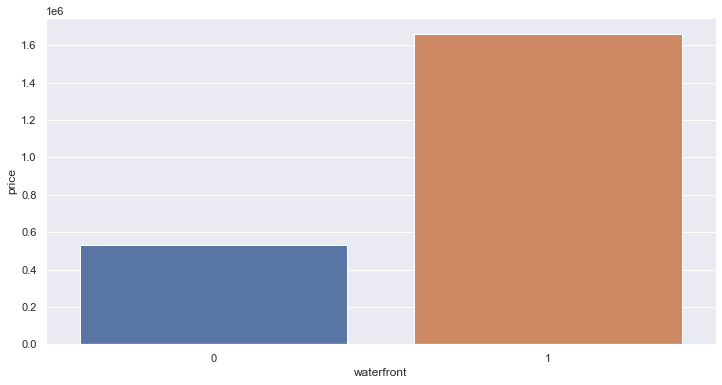

In [102]:
# Hipotese 1 - Imóveis que possuem vista para água, são 30% mais caros na media.

house_waterfront = data[['price','waterfront']].groupby('waterfront').mean().reset_index()
sns.barplot(y = house_waterfront['price'], x = house_waterfront['waterfront'])

In [103]:
house_waterfront 
1661876.02/533061.43 # False. Pois os imóveis com vista para água são 3x mais valorizados que os imóveis sem vista para água. Evidenciando, que a compra de imóveis 

3.117606951979249

In [104]:
# Hipotese 2 - Imóveis com data de construção menor que 1955, são 50% mais baratas, na média.

data['yr_old'] = data['yr_built'].apply (lambda x: 'old' if (x <= 1955) else 'new')

<AxesSubplot:xlabel='yr_old', ylabel='price'>

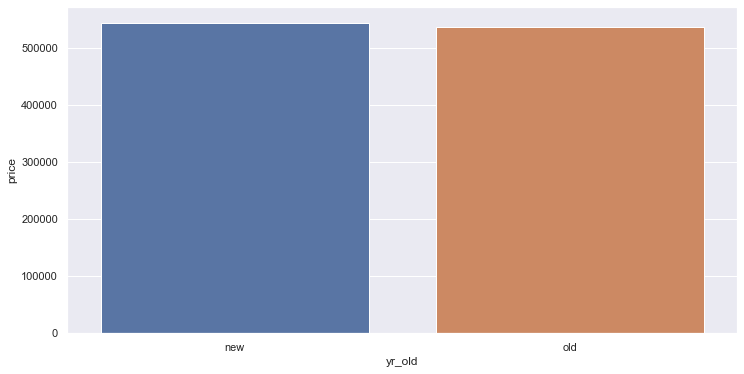

In [105]:
yr_old = data[['price','yr_old']].groupby('yr_old').mean().reset_index()
sns.barplot(y = yr_old['price'], x = yr_old['yr_old']) #false

In [101]:
yr_old
543873.83/536359.76

1.0140093842983298

In [34]:
# Hipotese 3 - Imóveis sem porão possuem área total 40% maiores do que os imóveis com porão 
data['basement'] = data['sqft_basement'].apply(lambda x: 'yes' if (x != 0) else 'no')

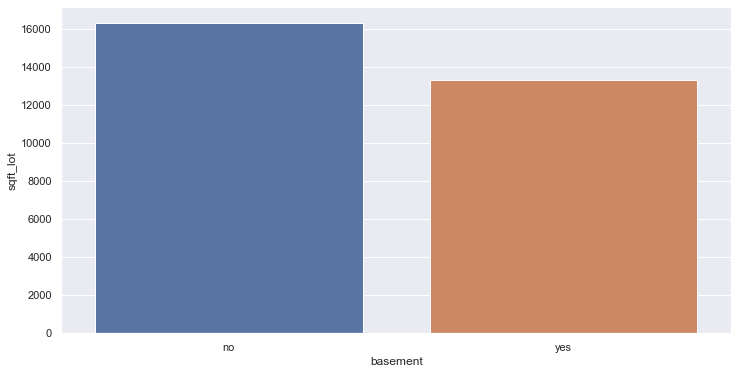

In [75]:
basement_area = data[['sqft_lot','basement']].groupby('basement').mean().reset_index()
sns.barplot(y = basement_area['sqft_lot'], x = basement_area['basement']);

In [36]:
basement
16325.95/13296.86 #False 

1.2278049103322137

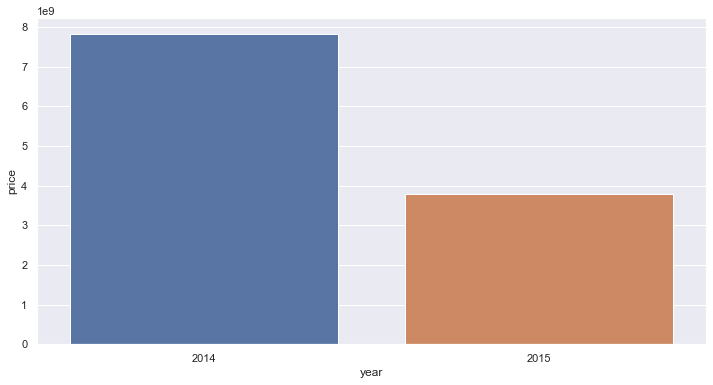

In [48]:
# Hipotese 4 - O crescimento do preço dos imóveis YoY é de 10%

yoy = data[['price','year']].groupby('year').sum().reset_index()
sns.barplot(y=yoy['price'],x=yoy['year']); #False, de 2014 para 2015, houve uma queda nos preços dos imóveis.

In [45]:
yoy

,year,price
0,2014,7829223260.00
1,2015,3780945341.00


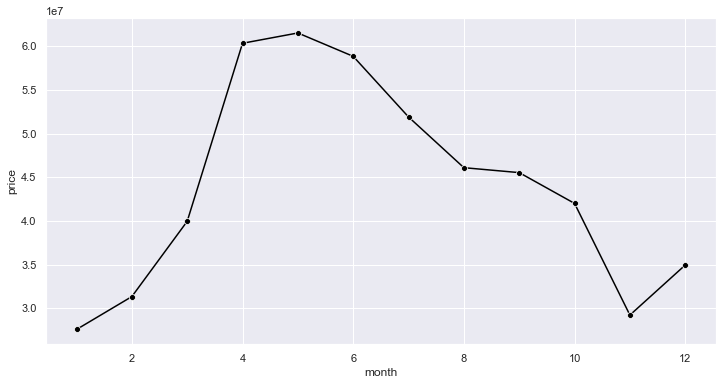

In [56]:
# Hipotese 5 - Imóveis com 3 banheiros tem um crescimento de preço MoM de 15%

bathrooms_price = data[['month','price','bathrooms']].groupby(['month', 'bathrooms']).sum().reset_index()
bathrooms_price2 = bathrooms_price[bathrooms_price.bathrooms ==3]
sns.lineplot(y=bathrooms_price2.price, x= bathrooms_price2.month, color = 'black', markers = True, style = (1), legend = False);

In [106]:
#False, o gráfico varia com crescimentos e decaimentos. Os meses de janeiro, fevereiro, e novembro, são bons meses para compra de imóveis com 3 banheiro e os meses abril, maio e junho, são os melhores para venda.

In [60]:
#Hipoteses 6 - Imóveis com condições boas (3 ou mais), são 30% mais caros, na média

data['state'] = data['condition'].apply(lambda x: 'good' if (x>=3) else 'bad')

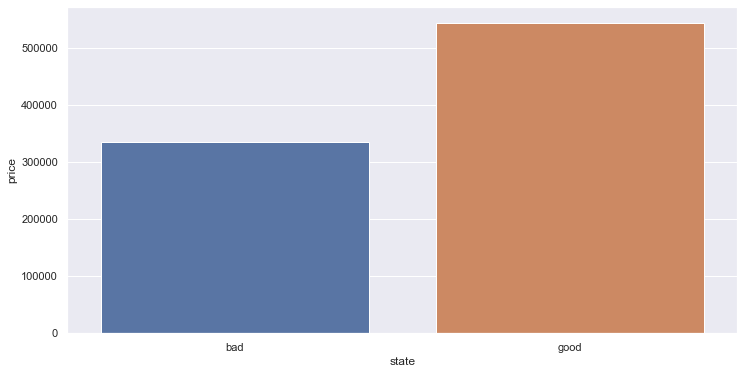

In [63]:
state_houses = data[['price','state']].groupby('state').mean().reset_index()
sns.barplot(y=state_houses['price'],x=state_houses['state']);

In [65]:
state_houses

543528.35/334400.72 # False, casas em bom estado são 62% mais caras. É lucrativo, comprar casas em condições ruins e vender em boas condições. 

1.6253803221476317

In [68]:
#Hipotese 7 - Imóveis que já tiveram pelo menos uma reforma, são 40% mais caros, na média.
data['remodeling'] = data['yr_renovated'].apply(lambda x: 'yes' if (x!=0) else 'no')

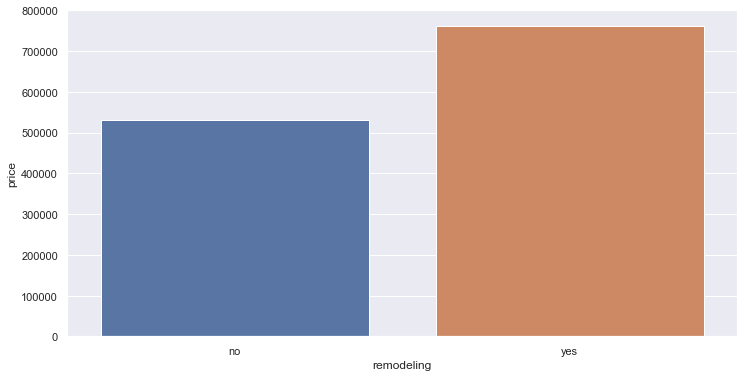

In [73]:
remodeling_houses = data[['price', 'remodeling']].groupby('remodeling').mean().reset_index()
sns.barplot(y=remodeling_houses['price'], x=remodeling_houses['remodeling']);

In [71]:
remodeling_houses 
762118.06/531870.46 #True, as casas que ja foram reformadas pelo menos uma vez, tem um aumento de 40% preço, reafirmando que o negócio de compra/reformar/venda é lucrativo. 

1.4329016505259573

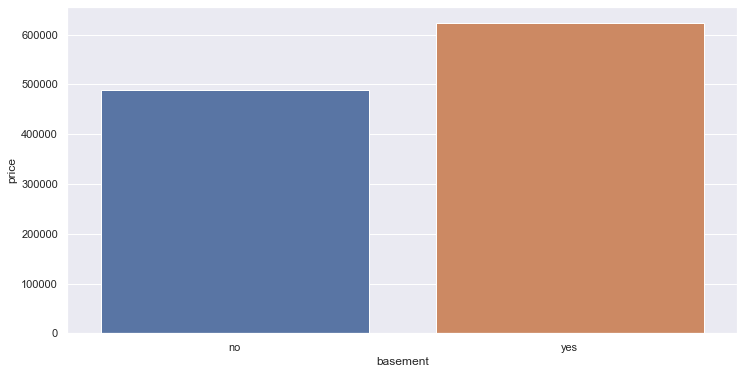

In [80]:
#Hipotese 8 - Casas com porão, são 30% mais caras que as casam sem porão, em média.

basement_price = data[['price', 'basement']].groupby('basement').mean().reset_index()
sns.barplot(y=basement_price['price'], x=basement_price['basement']);

In [78]:
basement_price
623965.42/488388.76 #True, as casas que possuem porão são 30% mais caras, invista em casa com porão abaixo da média de preços. 

1.277599877605701

In [87]:
#Hipotese 9 - Casa com boa vista, são 30% mais caras que as casam que não possuem, em média.
data['view_condition'] = data['view'].apply(lambda x: 'good'if (x>=2) else 'bad')

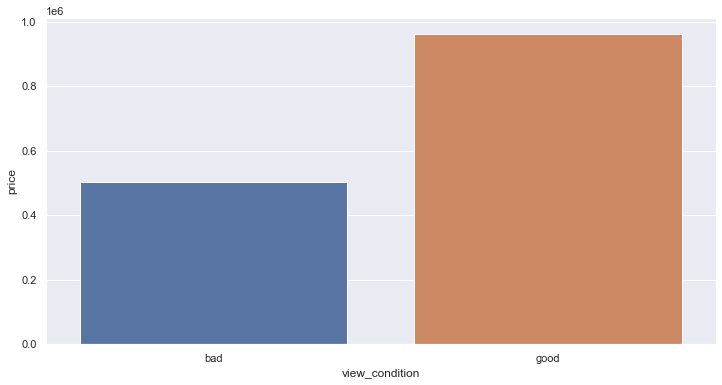

In [89]:
view_good = data[['price','view_condition']].groupby('view_condition').mean().reset_index() 
sns.barplot(y=view_good['price'], x=view_good['view_condition']);

In [88]:
view_good
962781.59/503389.49 #False, casa com boa vista são quase o dobro (91%) do preço das casas com vista ruim, investir em casas com boa vista, abaixo da média, sao lucrativas

1.9125977183194667

In [90]:
#Hipotese 10  - Imóveis com 3 quartos ou mais, são 40% mais caros que os imóveis com menos, em média. 
data['amount_bedrooms'] = data['bedrooms'].apply(lambda x: 'many' if (x>=3) else 'little')

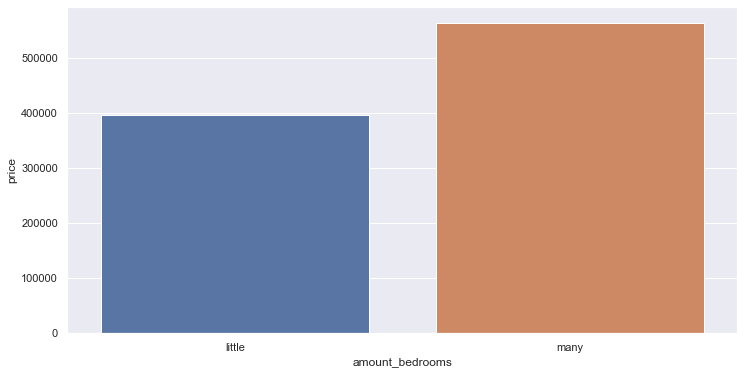

In [94]:
bedrooms_houses = data[['price','amount_bedrooms']].groupby('amount_bedrooms').mean().reset_index()
sns.barplot(y=bedrooms_houses['price'], x=bedrooms_houses['amount_bedrooms']);

In [93]:
bedrooms_houses
564678.45/396919.74 #True, investir em casas com mais quartos e que estão abaixo da média, é lucrativo 

1.4226514660117433